In [1]:
!pip install gymnasium
import matplotlib.pyplot as plt
import importlib.util
import numpy as np
import random
import copy
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib


You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


### Agents

In [2]:
## SARSA ##

class SarsaAgent(object):
    """The world's simplest agent!"""
    def __init__(self, state_space, action_space):
        self.action_space = action_space
        self.state_space = state_space
        self.Q = np.random.rand(self.state_space, self.action_space)
        self.epsilon = 0.05
        self.gamma = 0.95
        self.alpha = 0.05
        self.next_action = np.random.randint(self.action_space)

    def observe(self, observation, reward, done):
    
        if not done:
            if np.random.rand() < self.epsilon: # Explore
                self.next_action =  np.random.randint(self.action_space)
            else:
                self.next_action = np.argmax(self.Q[self.current_state])
            
            self.Q[self.current_state, self.action] = self.Q[self.current_state, self.action] + self.alpha*(reward + self.gamma * self.Q[observation, self.next_action] - self.Q[self.current_state, self.action])
        else:
            self.next_action = np.random.randint(self.action_space)
            self.Q[self.current_state, self.action] = self.Q[self.current_state, self.action] + self.alpha*(reward  - self.Q[self.current_state, self.action])

    def act(self, observation):
        self.current_state = observation
        self.action = self.next_action
        return self.action

In [3]:
## Expected SARSA ##


class ExpSarsaAgent(object):
    """The world's simplest agent!"""
    def __init__(self, state_space, action_space):
        self.action_space = action_space
        self.state_space = state_space
        self.Q = np.random.rand(self.state_space, self.action_space) 
        self.epsilon = 0.05
        self.gamma = 0.95
        self.alpha = 0.05
        #self.next_action = np.random.randint(self.action_space)

    def observe(self, observation, reward, done):
    
        if not done:
            optimal_action_from_observation = np.argmax(self.Q[observation])
            action_probs = [self.epsilon/self.action_space]*self.action_space
            action_probs[optimal_action_from_observation] = action_probs[optimal_action_from_observation] + (1-self.epsilon)
            action_probs = np.array(action_probs)
            self.Q[self.current_state, self.action] = self.Q[self.current_state, self.action] + self.alpha*(reward + self.gamma * np.sum(action_probs*[self.Q[observation, a] for a in range(self.action_space)]) - self.Q[self.current_state, self.action])
        else:
            self.Q[self.current_state, self.action] = self.Q[self.current_state, self.action] + self.alpha*(reward  - self.Q[self.current_state, self.action])

    def act(self, observation):
        self.current_state = observation
        if np.random.rand() < self.epsilon: # Explore
            self.action =  np.random.randint(self.action_space)
        else:
            self.action = np.argmax(self.Q[self.current_state])

        return self.action

In [4]:
## Q-learning ##

class QAgent(object):
    """The world's simplest agent!"""
    def __init__(self, state_space, action_space):
        self.action_space = action_space
        self.state_space = state_space
        self.Q = np.random.rand(self.state_space, self.action_space) 
        self.epsilon = 0.05
        self.gamma = 0.95
        self.alpha = 0.05
        #self.next_action = np.random.randint(self.action_space)

    def observe(self, observation, reward, done):
    
        if not done:
            self.Q[self.current_state, self.action] = self.Q[self.current_state, self.action] + self.alpha*(reward + self.gamma * np.max(self.Q[observation]) - self.Q[self.current_state, self.action])
        else:
            self.Q[self.current_state, self.action] = self.Q[self.current_state, self.action] + self.alpha*(reward  - self.Q[self.current_state, self.action])

    def act(self, observation):
        self.current_state = observation
        if np.random.rand() < self.epsilon: # Explore
            self.action =  np.random.randint(self.action_space)
        else:
            self.action = np.argmax(self.Q[self.current_state])

        return self.action

In [5]:
## Double Q-learning ##

class DoubleQAgent(object):
    """The world's simplest agent!"""
    def __init__(self, state_space, action_space):
        self.action_space = action_space
        self.state_space = state_space
        self.Q1 = np.random.rand(self.state_space, self.action_space) 
        self.Q2 = np.random.rand(self.state_space, self.action_space) 

        self.epsilon = 0.05
        self.gamma = 0.95
        self.alpha = 0.05
        #self.next_action = np.random.randint(self.action_space)

    def observe(self, observation, reward, done):
    
        if not done:
            if np.random.rand() < 0.5:
                self.Q1[self.current_state, self.action] = self.Q1[self.current_state, self.action] + self.alpha*(reward + self.gamma * self.Q2[observation, np.argmax(self.Q1[observation])] - self.Q1[self.current_state, self.action])
            else:
                self.Q2[self.current_state, self.action] = self.Q2[self.current_state, self.action] + self.alpha*(reward + self.gamma * self.Q1[observation, np.argmax(self.Q2[observation])] - self.Q2[self.current_state, self.action])
        else:
            if np.random.rand() < 0.5:
                self.Q1[self.current_state, self.action] = self.Q1[self.current_state, self.action] + self.alpha*(reward - self.Q1[self.current_state, self.action])
            else:
                self.Q2[self.current_state, self.action] = self.Q2[self.current_state, self.action] + self.alpha*(reward - self.Q2[self.current_state, self.action])

        self.Q = np.add(self.Q1, self.Q2)
        
    def act(self, observation):
        tot_Q = np.add(self.Q1, self.Q2)

        self.current_state = observation
        if np.random.rand() < self.epsilon: # Explore
            self.action =  np.random.randint(self.action_space)
        else:
            self.action = np.argmax(tot_Q[self.current_state])

        return self.action

### Riverswim

In [6]:


# DO NOT MODIFY
class RiverSwim(gym.Env):
    def __init__(self, n=6, small=5/1000, large=1):
        self.n = n
        self.small = small  # payout for 'backwards' action
        self.large = large  # payout at end of chain for 'forwards' action
        self.state = 0  # Start at beginning of the chain
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Discrete(self.n)
        

    def step(self, action):
        assert self.action_space.contains(action)
        

        reward = 0

        if action == 0:  # Go left
            if self.state == 0:
                reward = self.small
            else:
                self.state -= 1
        else:
            if self.state == 0:  # 'forwards': go up along the chain
                self.state = np.random.choice([self.state, self.state + 1], p=[0.4, 0.6])
            elif self.state < self.n - 1:  # 'forwards': go up along the chain
                self.state = np.random.choice([self.state-1, self.state, self.state + 1], p=[0.05, 0.6, 0.35])
            else:
                self.state = np.random.choice([self.state-1, self.state], p=[0.4, 0.6])
                if self.state == self.n-1:
                    reward = self.large
        done = False
        return self.state, reward, done, False, {}


    def reset(self, seed=None, options=None):
        self.state = 0
        return self.state, {}

### Run experiment

In [7]:
def run_experiment(agent_type, nr_of_episodes, env_name):
    if env_name == "FrozenLake-v1":
        return run_experiment_frozen(agent_type, nr_of_episodes)
    else:
        return run_experiment_river(agent_type, nr_of_episodes)

# Problem 2

### FrozenLake environment

In [8]:
def set_terminal_states_zero(agent, action_space):
    # Set q-values of terminal state to 0
    agent.Q[-1] = np.zeros(action_space)
    agent.Q[5] = np.zeros(action_space)
    agent.Q[7] = np.zeros(action_space)
    agent.Q[11] = np.zeros(action_space)
    agent.Q[12] = np.zeros(action_space)

def set_terminal_states_zero_doubleq(agent, action_space):
    # Set q-values of terminal state to 0
    agent.Q1[-1] = np.zeros(action_space)
    agent.Q1[5] = np.zeros(action_space)
    agent.Q1[7] = np.zeros(action_space)
    agent.Q1[11] = np.zeros(action_space)
    agent.Q1[12] = np.zeros(action_space)

    agent.Q2[-1] = np.zeros(action_space)
    agent.Q2[5] = np.zeros(action_space)
    agent.Q2[7] = np.zeros(action_space)
    agent.Q2[11] = np.zeros(action_space)
    agent.Q2[12] = np.zeros(action_space)

def run_experiment_frozen(agent_type, nr_of_episodes):


    env = gym.make("FrozenLake-v1")#, desc=["SFFF", "FFFH", "FFFF", "FFFG"])

    print("Loaded FrozenLake")
    
    Q_list = []
    results_avg = []
    action_dim = env.action_space.n
    state_dim = env.observation_space.n
    
    
    for run in range(5): # Five runs

        if agent_type == "sarsa":
            agent = SarsaAgent(state_dim, action_dim)
            set_terminal_states_zero(agent, action_dim)
        elif agent_type == "q":
            agent = QAgent(state_dim, action_dim)
            set_terminal_states_zero(agent, action_dim)
        elif agent_type == "doubleq":
            agent = DoubleQAgent(state_dim, action_dim)
            set_terminal_states_zero_doubleq(agent, action_dim)
        elif agent_type == "expsarsa":
            agent = ExpSarsaAgent(state_dim, action_dim)
            set_terminal_states_zero(agent, action_dim)

        observation = env.reset()
        observation = observation[0]
        moving_average_rewards = []
        rewards_list = []
        
        for _ in range(nr_of_episodes):
            rewards = 0
            done = False
            while not done:
                #env.render()
                action = agent.act(observation) # your agent here (this currently takes random actions)
                observation, reward, done, truncated, info = env.step(action)
                #if done:
                #    print(done)
                #    print(reward)
                #rewards.append(reward)
                rewards += reward
                agent.observe(observation, reward, done)
                
            observation, info = env.reset()
            rewards_list.append(rewards)
            moving_average_rewards.append(np.mean(rewards_list[-500:]))
            #moving_average_rewards.append(moving_average(rewards_list, 500))
        Q_list.append(copy.copy(agent.Q))
        results_avg.append(moving_average_rewards)

    env.close()
    ci = [1.96*np.std([results_avg[0][i], results_avg[1][i], results_avg[2][i], results_avg[3][i], results_avg[4][i]]) / np.sqrt(5) for i in range(len(results_avg[0]))]
    Q_avg = np.mean(Q_list,axis=0)
    results_avg_over_runs = np.mean(results_avg, axis = 0)
    return results_avg_over_runs, ci, Q_avg
    


In [9]:
def plot_moving_avg(agent, nr_episodes, env_name):
    results, ci, Q_avg = run_experiment(agent, nr_episodes, env_name)
    x = list(range(nr_episodes))
    plt.plot(x, results, color = "black")
    #ci = 1.96 * np.std(results) / np.sqrt(len(results))
    plt.fill_between(x, results - ci, results + ci, alpha = 0.5)
    if env_name == "RiverSwim":
        plt.title(f"Moving average over 5 runs with {nr_episodes} steps \n with {agent} agent in environment {env_name}")
        plt.ylabel("Average reward")
        plt.xlabel("Steps")
    else:
        plt.title(f"Moving average over 5 runs with {nr_episodes} episodes \n with {agent} agent in environment {env_name}")
        plt.ylabel("Average reward")
        plt.xlabel("Episode")
    plt.savefig(f"mov_avg_{agent}_{env_name}.png")
    plt.show()

Loaded FrozenLake


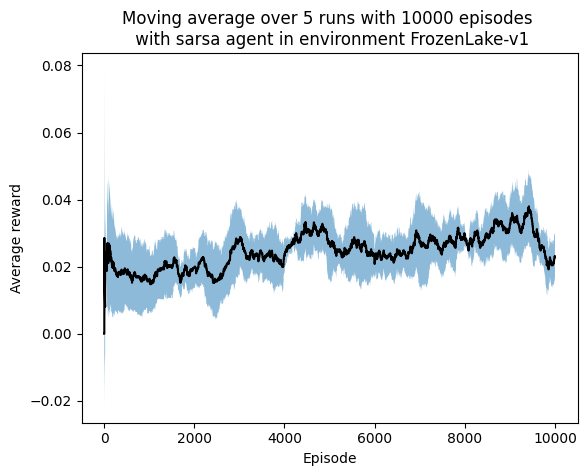

In [10]:
# Moving average of SARSA agent
plot_moving_avg("sarsa", 10000, "FrozenLake-v1")

Loaded FrozenLake


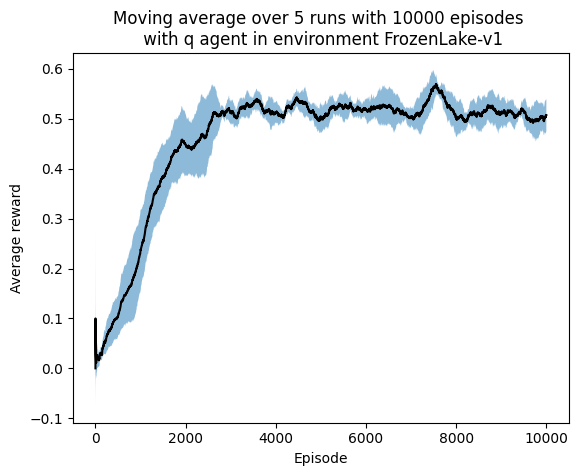

In [11]:
# Moving average of Q-learning agent

plot_moving_avg("q", 10000, "FrozenLake-v1")

Loaded FrozenLake


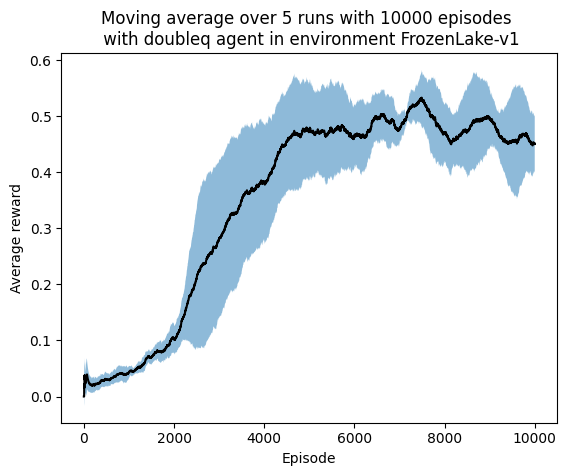

In [12]:
# Moving average of Double Q-learning agent

plot_moving_avg("doubleq", 10000, "FrozenLake-v1")

Loaded FrozenLake


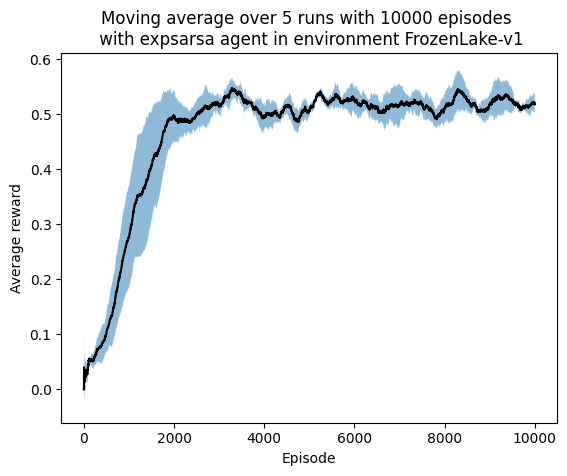

In [13]:
# Moving average of Expected SARSA agent

plot_moving_avg("expsarsa", 10000, "FrozenLake-v1")

### Riverswim environment

In [14]:


def run_experiment_river(agent_type, nr_of_steps):

    env = RiverSwim()
    print("Loaded RiverSwim")
    
    Q_list = []
    results_avg = []
    action_dim = env.action_space.n
    state_dim = env.observation_space.n

    
    
    
    for run in range(5): # Five runs

        if agent_type == "sarsa":
            agent = SarsaAgent(state_dim, action_dim)
        elif agent_type == "q":
            agent = QAgent(state_dim, action_dim)
        elif agent_type == "doubleq":
            agent = DoubleQAgent(state_dim, action_dim)
        elif agent_type == "expsarsa":
            agent = ExpSarsaAgent(state_dim, action_dim)

        observation = env.reset()
        observation = observation[0]
        moving_average_rewards = []
        rewards_list = []
        done = False
        for _ in range(nr_of_steps):
            
            #env.render()
            action = agent.act(observation)
            observation, reward, done, truncated, info = env.step(action)
            agent.observe(observation, reward, done)
            
            if done:
                observation, info = env.reset()

            rewards_list.append(reward)
            moving_average_rewards.append(np.mean(rewards_list[-500:]))
            
        Q_list.append(copy.copy(agent.Q))
        results_avg.append(moving_average_rewards)

    env.close()

    ci = [1.96*np.std([results_avg[0][i], results_avg[1][i], results_avg[2][i], results_avg[3][i], results_avg[4][i]]) / np.sqrt(5) for i in range(len(results_avg[0]))]

    Q_avg = np.mean(Q_list,axis=0)
    results_avg_over_runs = np.mean(results_avg, axis = 0)
    return results_avg_over_runs, ci, Q_avg
    


Loaded RiverSwim


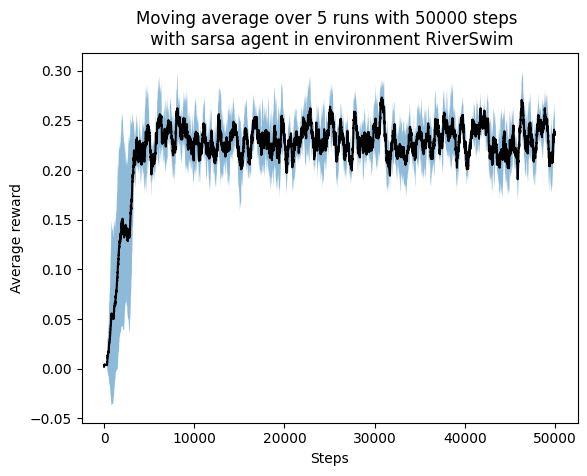

In [15]:
# Moving average of SARSA agent
plot_moving_avg("sarsa", 50000, "RiverSwim")

Loaded RiverSwim


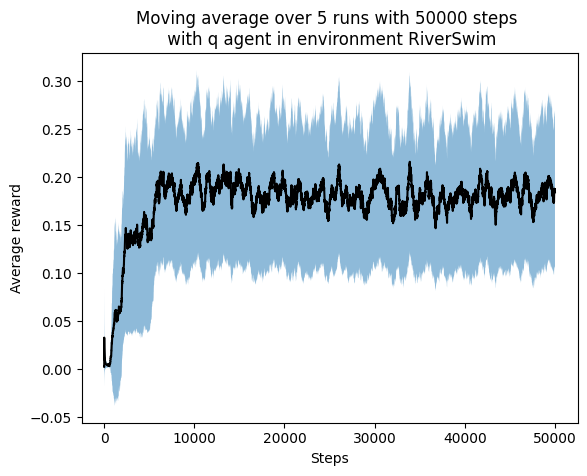

In [16]:
# Moving average of Q-learning agent

plot_moving_avg("q", 50000, "RiverSwim")

Loaded RiverSwim


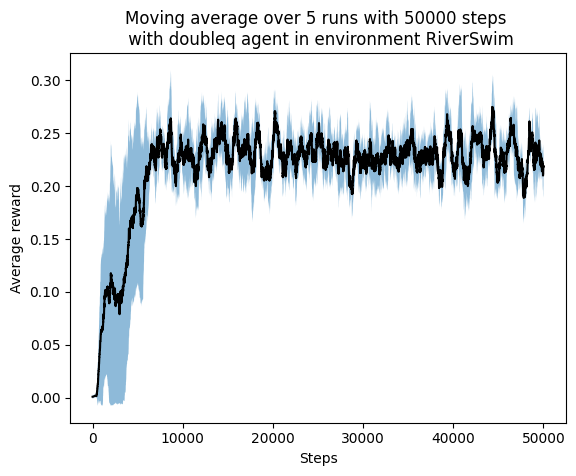

In [17]:
# Moving average of Double Q-learning agent

plot_moving_avg("doubleq", 50000, "RiverSwim")

Loaded RiverSwim


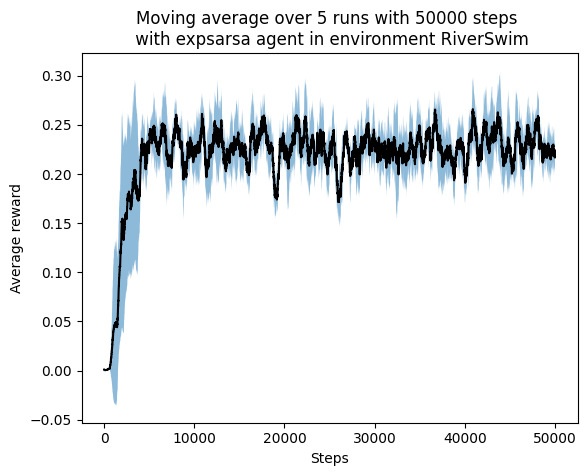

In [18]:
# Moving average of Expected SARSA agent

plot_moving_avg("expsarsa", 50000, "RiverSwim")

# Problem 3

In [19]:
def plot_policy_matrix(P: dict, S:np.array, goal_coords: list = [], water_coords: list=[], img_width: int = 4, img_height: int = 4, title: str = None, agent: str = None, env: str = None) -> None: 
    """ 
    Plots the policy matrix out of the dictionary provided; The dictionary values are used to draw the arrows 
    """
    height, width = S.shape

    fig = plt.figure(figsize=(img_width, img_width))
    ax = fig.add_subplot(111, aspect='equal')
    for y in range(height):
        for x in range(width):
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)
            
            # If there is a tuple of (x, y) in the goal_coords list, we color the cell gray 
            if (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))
            if (x, y) in water_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))
            
            else:
                # Adding the arrows to the plot
                if 'up' in P[S[x, y]]:
                    plt.arrow(matplot_x, matplot_y, 0, 0.3, head_width = 0.05, head_length = 0.05)
                if 'down' in P[S[x, y]]:
                    plt.arrow(matplot_x, matplot_y, 0, -0.3, head_width = 0.05, head_length = 0.05)
                if 'left' in P[S[x, y]]:
                    plt.arrow(matplot_x, matplot_y, -0.3, 0, head_width = 0.05, head_length = 0.05)
                if 'right' in P[S[x, y]]:
                    plt.arrow(matplot_x, matplot_y, 0.3, 0, head_width = 0.05, head_length = 0.05)


    offset = .5    
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)
    plt.savefig(f"policy_matrix_{agent}_{env}")
    plt.show()

def plot_Q_table(Q, img_width: int = 4, img_height: int = 4, title: str = None, agent: str = None, env: str = None) -> None: 
    """ 
    Plots the policy matrix out of the dictionary provided; The dictionary values are used to draw the arrows 
    """
    height = img_height
    width = img_width


    fig = plt.figure(figsize=(img_width, img_width))
    ax = fig.add_subplot(111, aspect='equal')
    for y in range(height):
        for x in range(width):
            i = y*4 + x
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)
            
            # If there is a tuple of (x, y) in the goal_coords list, we color the cell gray 
            if (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))
            if (x, y) in water_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))
            
            x_temp = y
            y_temp = x
            matplot_x, matplot_y = array_index_to_matplot_coords(x_temp, y_temp, height)

            center_offset = 0.25
            x_offset = -0.15
            y_offset = -0.1


            for ind in range(4):
                if ind == 0:
                    text_x = matplot_x - center_offset + x_offset 
                    text_y = matplot_y + y_offset
                if ind == 1:
                    text_x = matplot_x + x_offset
                    text_y = matplot_y - center_offset + y_offset
                if ind == 2:
                    text_x = matplot_x + center_offset  + x_offset
                    text_y = matplot_y + y_offset
                if ind == 3:
                    text_x = matplot_x + x_offset
                    text_y = matplot_y + center_offset + y_offset
                
                plt.text(text_x, text_y, str(np.round(Q[i,ind], 2)))


    offset = .5    
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)
    plt.savefig(f"q_viz_{agent}_{env}")
    plt.show()




def array_index_to_matplot_coords(i: int, j: int, n_cols: int) -> tuple[int, int]:
    """Converts an array index to a matplot coordinate"""
    x = j
    y = n_cols - i - 1
    return x, y

Loaded FrozenLake
[0 3 0 3 0 0 3 0 1 1 1 0 0 2 2 0]


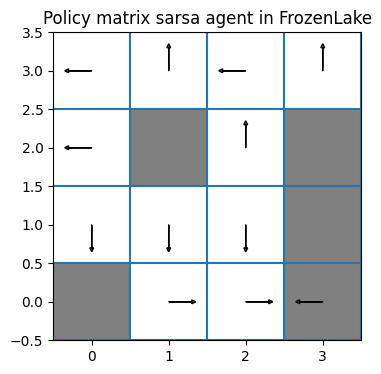

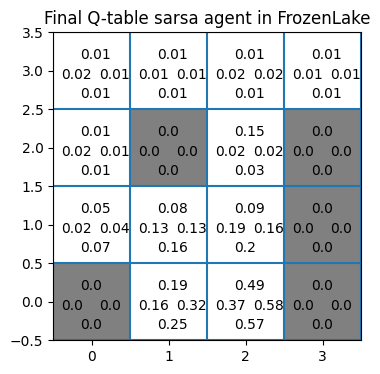

Loaded FrozenLake
[0 3 0 3 0 0 2 0 3 1 0 0 0 2 1 0]


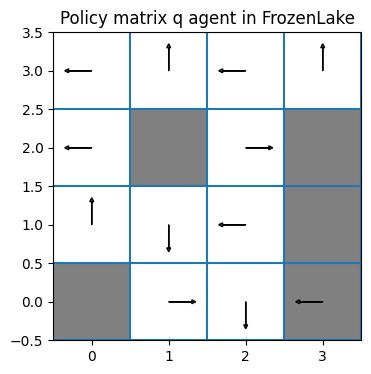

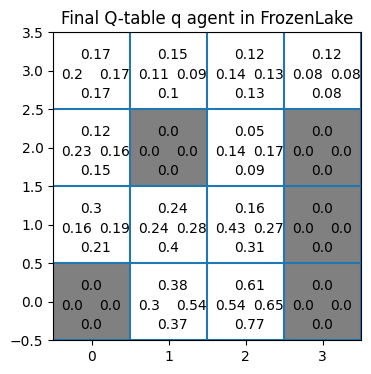

Loaded FrozenLake
[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]


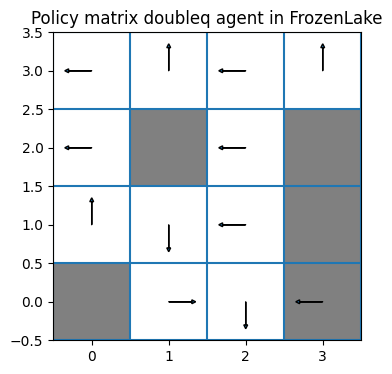

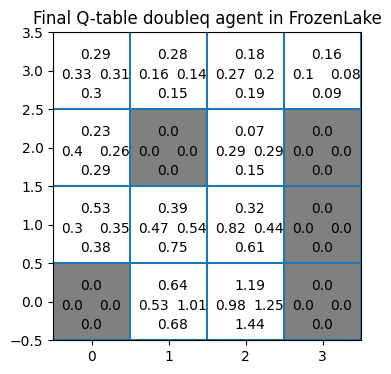

Loaded FrozenLake
[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]


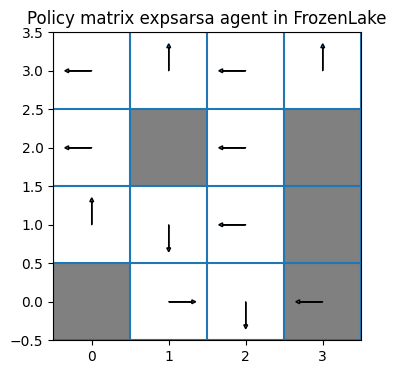

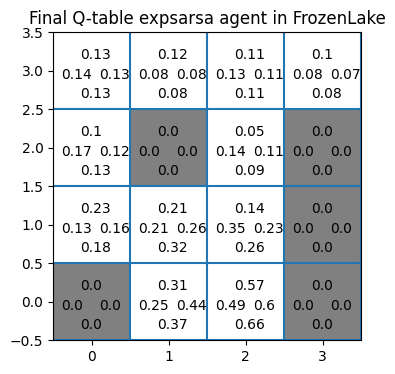

In [20]:
# Drawing a plot for the policy matrix with arrows; In one cell there can be the maximum of 4 arrows each indicating the action an agent can take 

n = 4
goal_coords = [(n-1, n-1)]
#goal_coords = [(0, n-1), (n-1, 0), (0, 0), (n-1, n-1), (n // 2, n // 2)]
water_coords = [(3,0),(1,1),(1,3),(2,3)]
S = np.arange(0, n*n).reshape(n, n)


nr_episodes = 10000
for agent_type in ["sarsa", "q", "doubleq", "expsarsa"]:
    results, conv_intervals, Q_avg = run_experiment(agent_type, nr_episodes, env_name="FrozenLake-v1")
    
    Q_final = Q_avg
    policy = np.argmax(Q_final,1)
    print(policy)
    P = {}
    for i in range(len(policy)):
        s_dict = {}
        if policy[i] == 0:
            s_dict['left'] = 1
        if policy[i] == 1:
            s_dict['down'] = 1
        if policy[i] == 2:
            s_dict['right'] = 1
        if policy[i] == 3:
            s_dict['up'] = 1

        P[i] = s_dict

    plot_policy_matrix(P, S, goal_coords, water_coords, title=f'Policy matrix {agent_type} agent in FrozenLake', agent = agent_type, env = "FrozenLake")
    plot_Q_table(Q_final, title=f'Final Q-table {agent_type} agent in FrozenLake', agent = agent_type, env = "FrozenLake")

In [21]:
def plot_policy_matrix_riverswim(P: dict, S:np.array, img_width: int = 6, title: str = 'Riverswim policy', agent: str = None, env: str = None) -> None: 
    """ 
    Plots the policy matrix out of the dictionary provided; The dictionary values are used to draw the arrows 
    """
    width = len(S)
    height = 1

    fig = plt.figure()#figsize=(img_width, 1))
    ax = fig.add_subplot(111, aspect='equal')
    for i in range(len(S)):
        matplot_x, matplot_y = array_index_to_matplot_coords(0, i, 1)
        # Adding the arrows to the plot
        if 'left' in P[S[i]]:
            plt.arrow(matplot_x, matplot_y, -0.3, 0, head_width = 0.05, head_length = 0.05)
        if 'right' in P[S[i]]:
            plt.arrow(matplot_x, matplot_y, 0.3, 0, head_width = 0.05, head_length = 0.05)


    offset = .5    
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)
    plt.savefig(f"policy_matrix_{agent}_{env}")
    plt.show()

def plot_Q_table_riverswim(Q, img_width: int = 6, title: str = None, agent: str = None, env: str = None) -> None: 
    """ 
    Plots the policy matrix out of the dictionary provided; The dictionary values are used to draw the arrows 
    """
    height = 1
    width = len(S)


    fig = plt.figure()#figsize=(img_width, 1))
    ax = fig.add_subplot(111, aspect='equal')
    for i in range(width):
        matplot_x, matplot_y = array_index_to_matplot_coords(0, i, 1)


        center_offset = 0.25
        x_offset = -0.15
        y_offset = -0.1


        for ind in range(2):
            if ind == 0:
                text_x = matplot_x - center_offset + x_offset 
                text_y = matplot_y + y_offset
            if ind == 1:
                text_x = matplot_x + center_offset  + x_offset
                text_y = matplot_y + y_offset
            
            plt.text(text_x, text_y, str(np.round(Q[i,ind], 2)))


    offset = .5    
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)

    ax.hlines(y=np.arange(height+1)- offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)
    plt.savefig(f"q_viz_{agent}_{env}")
    plt.show()




def array_index_to_matplot_coords(i: int, j: int, n_cols: int) -> tuple[int, int]:
    """Converts an array index to a matplot coordinate"""
    x = j
    y = n_cols - i - 1
    return x, y

[0 1 2 3 4 5]
Loaded RiverSwim
[1 1 1 1 1 1]


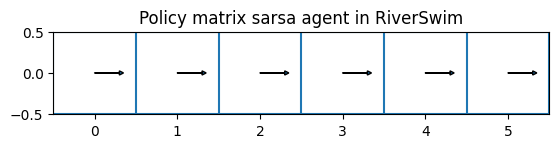

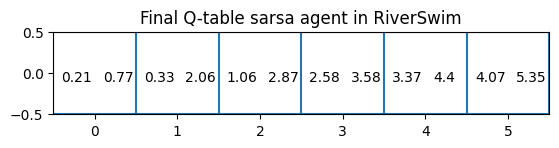

Loaded RiverSwim
[1 1 1 1 1 1]


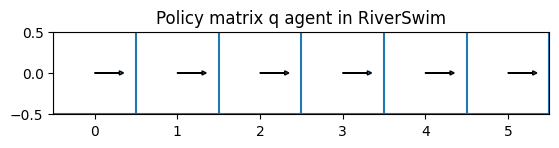

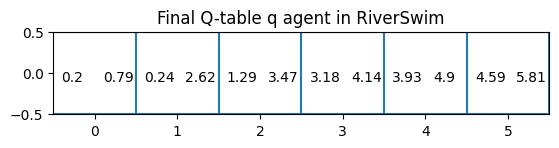

Loaded RiverSwim
[1 1 1 1 1 1]


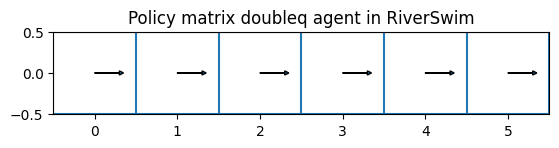

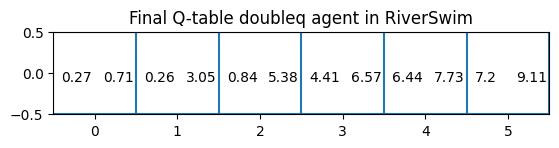

Loaded RiverSwim
[1 1 1 1 1 1]


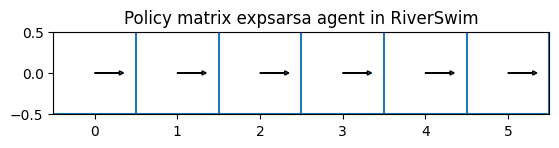

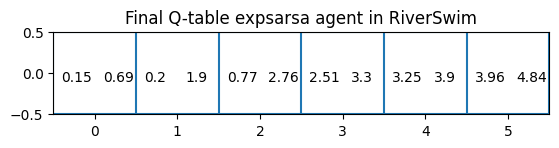

In [22]:
# Drawing a plot for the policy matrix with arrows; In one cell there can be the maximum of 4 arrows each indicating the action an agent can take 
n = 6

S = np.arange(0, n)
print(S)
nr_episodes = 40000
for agent_type in ["sarsa", "q", "doubleq", "expsarsa"]:
    results, conv_intervals, Q_avg = run_experiment(agent_type, nr_episodes, env_name="RiverSwim")
    
    Q_final = Q_avg
    policy = np.argmax(Q_final,1)
    print(policy)
    P = {}
    for i in range(len(policy)):
        s_dict = {}
        if policy[i] == 0:
            s_dict['left'] = 1
        if policy[i] == 1:
            s_dict['right'] = 1

        P[i] = s_dict

    plot_policy_matrix_riverswim(P, S, title=f'Policy matrix {agent_type} agent in RiverSwim', agent = agent_type, env = "RiverSwim")
    plot_Q_table_riverswim(Q_final, title=f'Final Q-table {agent_type} agent in RiverSwim', agent = agent_type, env = "RiverSwim")

# Problem 4

In [23]:
## Expected SARSA modified for question 4##

class ExpSarsaAgentMod(object):

    def __init__(self, state_space, action_space):
        self.action_space = action_space
        self.state_space = state_space
        self.Q = np.random.uniform(0.8, 0.99, (self.state_space, self.action_space)) 
        self.epsilon = 0.05
        self.gamma = 0.95
        self.alpha = 0.05
        #self.next_action = np.random.randint(self.action_space)

    def observe(self, observation, reward, done):
    
        if not done:
            optimal_action_from_observation = np.argmax(self.Q[observation])
            action_probs = [self.epsilon/self.action_space]*self.action_space
            action_probs[optimal_action_from_observation] = action_probs[optimal_action_from_observation] + (1-self.epsilon)
            action_probs = np.array(action_probs)
            self.Q[self.current_state, self.action] = self.Q[self.current_state, self.action] + self.alpha*(reward + self.gamma * np.sum(action_probs*[self.Q[observation, a] for a in range(self.action_space)]) - self.Q[self.current_state, self.action])
        else:
            self.Q[self.current_state, self.action] = self.Q[self.current_state, self.action] + self.alpha*(reward  - self.Q[self.current_state, self.action])

    def act(self, observation):
        self.current_state = observation
        if np.random.rand() < self.epsilon: # Explore
            self.action =  np.random.randint(self.action_space)
        else:
            self.action = np.argmax(self.Q[self.current_state])

        return self.action

In [24]:
## Expected SARSA modified for question 4##

class ExpSarsaAgentModZero(object):

    def __init__(self, state_space, action_space):
        self.action_space = action_space
        self.state_space = state_space
        self.Q = np.zeros((self.state_space, self.action_space)) 
        self.epsilon = 0.05
        self.gamma = 0.95
        self.alpha = 0.05
        #self.next_action = np.random.randint(self.action_space)

    def observe(self, observation, reward, done):
    
        if not done:
            optimal_action_from_observation = np.argmax(self.Q[observation])
            action_probs = [self.epsilon/self.action_space]*self.action_space
            action_probs[optimal_action_from_observation] = action_probs[optimal_action_from_observation] + (1-self.epsilon)
            action_probs = np.array(action_probs)
            self.Q[self.current_state, self.action] = self.Q[self.current_state, self.action] + self.alpha*(reward + self.gamma * np.sum(action_probs*[self.Q[observation, a] for a in range(self.action_space)]) - self.Q[self.current_state, self.action])
        else:
            self.Q[self.current_state, self.action] = self.Q[self.current_state, self.action] + self.alpha*(reward  - self.Q[self.current_state, self.action])

    def act(self, observation):
        self.current_state = observation
        if np.random.rand() < self.epsilon or max(self.Q[self.current_state,:]) <= 0: # Explore
            self.action =  np.random.randint(self.action_space)
        else:
            self.action = np.argmax(self.Q[self.current_state])

        return self.action

In [25]:
def set_terminal_states_zero(agent, action_space):
    # Set q-values of terminal state to 0
    agent.Q[-1] = np.zeros(action_space)
    agent.Q[5] = np.zeros(action_space)
    agent.Q[7] = np.zeros(action_space)
    agent.Q[11] = np.zeros(action_space)
    agent.Q[12] = np.zeros(action_space)


def run_frozen_4(nr_of_episodes):

    env = gym.make("FrozenLake-v1")

    print("Loaded FrozenLake")
    
    
    action_dim = env.action_space.n
    state_dim = env.observation_space.n
    agent_results = []
    agent_qs = []
    
    for agent in [ExpSarsaAgent(state_dim, action_dim), ExpSarsaAgentMod(state_dim, action_dim), ExpSarsaAgentModZero(state_dim, action_dim)]:
        set_terminal_states_zero(agent, action_dim)
        run_list = []
        Q_list = []
    
        for run in range(5): # Five runs

            observation = env.reset()
            observation = observation[0]
            cumulative_reward = 0 
            rewards_list = [0]
            
            for _ in range(nr_of_episodes):
                rewards = 0
                done = False
                while not done:
                    #env.render()
                    action = agent.act(observation) # your agent here (this currently takes random actions)
                    observation, reward, done, truncated, info = env.step(action)
                    #if done:
                    #    print(done)
                    #    print(reward)
                    #rewards.append(reward)
                    rewards += reward
                    agent.observe(observation, reward, done)
                    
                observation, info = env.reset()
                cumulative_reward += rewards
                rewards_list.append(cumulative_reward)

            Q_list.append(copy.copy(agent.Q))
            run_list.append(rewards_list)
        agent_results.append(run_list)
        Q_avg = np.mean(Q_list,axis=0)
        agent_qs.append(Q_avg)

    env.close()

    avg_results_regular_agent = np.mean(agent_results[0], axis = 0)
    avg_results_mod_agent = np.mean(agent_results[1], axis = 0)
    avg_results_zero_agent = np.mean(agent_results[2], axis = 0)
    return avg_results_regular_agent, avg_results_mod_agent, avg_results_zero_agent, agent_qs
    


In [26]:
def run_river_4(nr_of_steps):

    env = RiverSwim()

    print("Loaded Riverswim")
    
    
    action_dim = env.action_space.n
    state_dim = env.observation_space.n
    agent_results = []
    agent_qs = []
    
    for agent in [ExpSarsaAgent(state_dim, action_dim), ExpSarsaAgentMod(state_dim, action_dim), ExpSarsaAgentModZero(state_dim, action_dim)]:
        run_list = []
        Q_list = []
    
        for run in range(5): # Five runs

            observation = env.reset()
            observation = observation[0]
            cumulative_reward = 0
            rewards_list = [0]
            done = False
            for _ in range(nr_of_steps):
                
                #env.render()
                action = agent.act(observation)
                observation, reward, done, truncated, info = env.step(action)
                agent.observe(observation, reward, done)
                cumulative_reward += reward

                rewards_list.append(cumulative_reward)
                #moving_average_rewards.append(np.mean(rewards_list[-500:]))
                
            Q_list.append(copy.copy(agent.Q))
            

            run_list.append(rewards_list)
        agent_results.append(run_list)
        Q_avg = np.mean(Q_list,axis=0)
        agent_qs.append(Q_avg)


    env.close()
    avg_results_regular_agent = np.mean(agent_results[0], axis = 0)
    avg_results_mod_agent = np.mean(agent_results[1], axis = 0)
    avg_results_zero_agent = np.mean(agent_results[2], axis = 0)
    return avg_results_regular_agent, avg_results_mod_agent, avg_results_zero_agent, agent_qs

Loaded FrozenLake


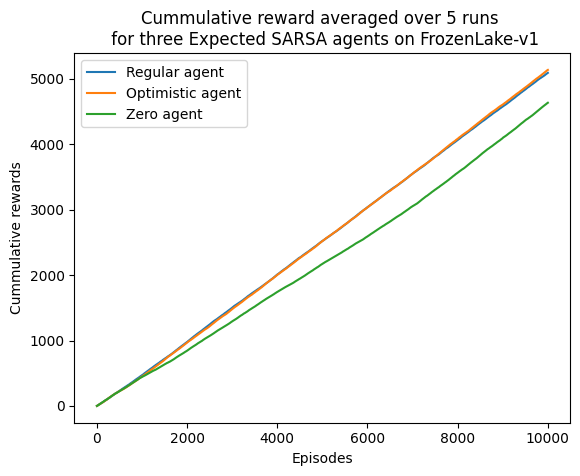

In [27]:
regular_frozen, mod_optimistic_frozen, zero_frozen, Q_list_frozen = run_frozen_4(10000)
plt.plot(list(range(len(regular_frozen))), regular_frozen, label="Regular agent")
plt.plot(list(range(len(mod_optimistic_frozen))), mod_optimistic_frozen, label = "Optimistic agent")
plt.plot(list(range(len(zero_frozen))), zero_frozen, label = "Zero agent")
plt.xlabel("Episodes")
plt.ylabel("Cummulative rewards")
plt.title("Cummulative reward averaged over 5 runs \n for three Expected SARSA agents on FrozenLake-v1")
plt.legend()
plt.savefig("modded_agents_frozen.png")

Loaded Riverswim


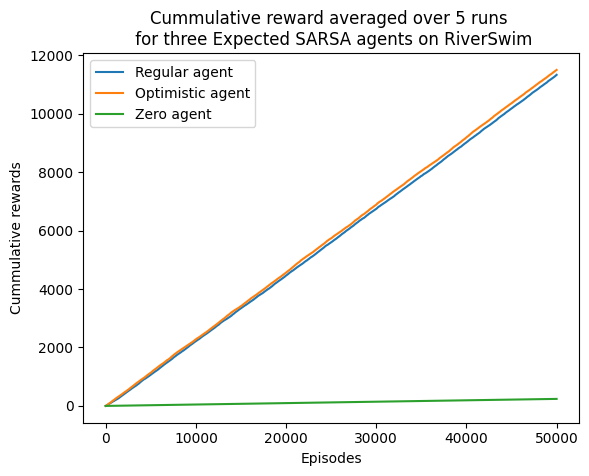

In [28]:
regular_river, mod_optimistic_river, zero_river, Q_list_river = run_river_4(50000)
plt.plot(list(range(len(regular_river))), regular_river, label="Regular agent")
plt.plot(list(range(len(mod_optimistic_river))), mod_optimistic_river, label = "Optimistic agent")
plt.plot(list(range(len(zero_river))), zero_river, label = "Zero agent")
plt.xlabel("Episodes")
plt.ylabel("Cummulative rewards")
plt.title("Cummulative reward averaged over 5 runs \n for three Expected SARSA agents on RiverSwim")
plt.legend()
plt.savefig("modded_agents_river.png")

[0 3 0 3 0 0 2 0 3 1 0 0 0 2 1 0]


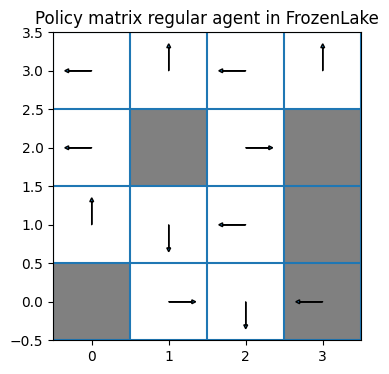

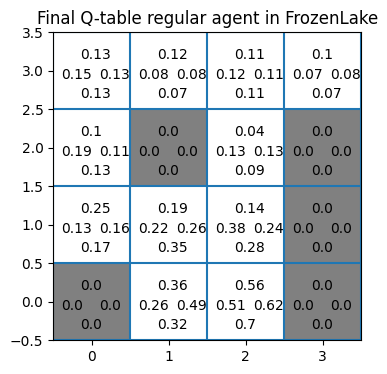

[0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]


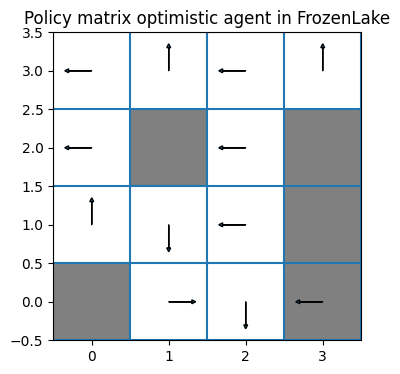

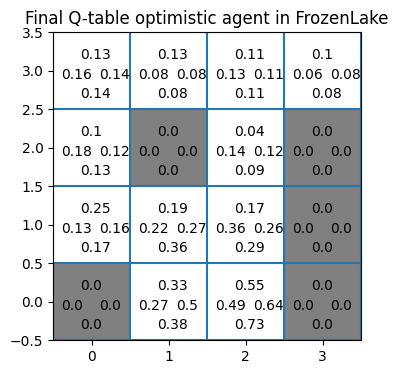

[0 3 0 3 0 0 2 0 3 1 0 0 0 2 1 0]


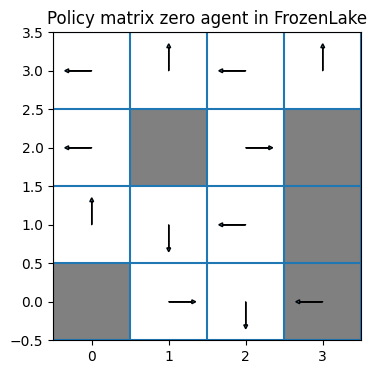

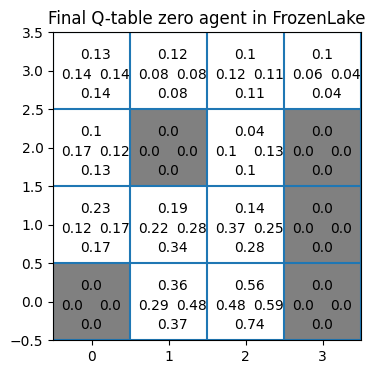

In [29]:
n = 4
goal_coords = [(n-1, n-1)]
#goal_coords = [(0, n-1), (n-1, 0), (0, 0), (n-1, n-1), (n // 2, n // 2)]
water_coords = [(3,0),(1,1),(1,3),(2,3)]
S = np.arange(0, n*n).reshape(n, n)


Q_final_regular = Q_list_frozen[0]
Q_final_mod = Q_list_frozen[1]
Q_final_zero = Q_list_frozen[2]

for agent_type in ["regular", "optimistic", "zero"]:
    if agent_type == "regular":
        Q_final = Q_final_regular
    elif agent_type == "optimistic":
        Q_final = Q_final_mod
    else:
        Q_final = Q_final_zero

    policy = np.argmax(Q_final,1)
    print(policy)
    P = {}
    for i in range(len(policy)):
        s_dict = {}
        if policy[i] == 0:
            s_dict['left'] = 1
        if policy[i] == 1:
            s_dict['down'] = 1
        if policy[i] == 2:
            s_dict['right'] = 1
        if policy[i] == 3:
            s_dict['up'] = 1

        P[i] = s_dict

    plot_policy_matrix(P, S, goal_coords, water_coords, title=f'Policy matrix {agent_type} agent in FrozenLake', agent = agent_type, env = "FrozenLake")
    plot_Q_table(Q_final, title=f'Final Q-table {agent_type} agent in FrozenLake', agent = agent_type, env = "FrozenLake")

[1 1 1 1 1 1]


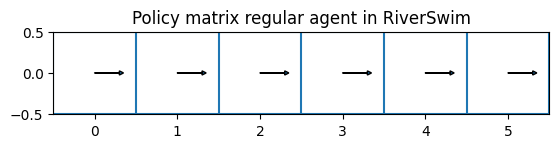

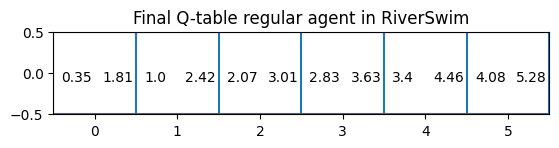

[1 1 1 1 1 1]


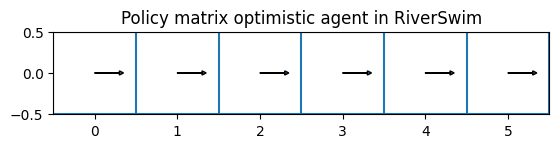

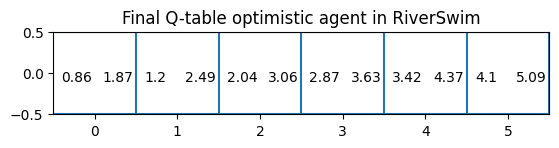

[0 0 0 0 0 0]


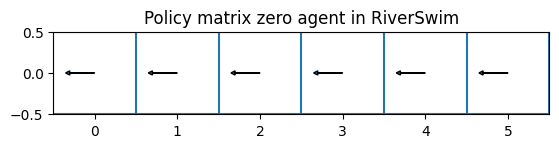

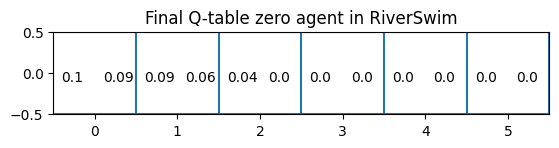

In [30]:
n = 6

S = np.arange(0, n)


Q_final_regular = Q_list_river[0]
Q_final_mod = Q_list_river[1]
Q_final_zero = Q_list_river[2]

for agent_type in ["regular", "optimistic", "zero"]:
    if agent_type == "regular":
        Q_final = Q_final_regular
    elif agent_type == "optimistic":
        Q_final = Q_final_mod
    else:
        Q_final = Q_final_zero

    policy = np.argmax(Q_final,1)
    print(policy)
    P = {}
    for i in range(len(policy)):
        s_dict = {}
        if policy[i] == 0:
            s_dict['left'] = 1
        if policy[i] == 1:
            s_dict['right'] = 1

        P[i] = s_dict

    plot_policy_matrix_riverswim(P, S, title=f'Policy matrix {agent_type} agent in RiverSwim', agent = agent_type, env = "RiverSwim")
    plot_Q_table_riverswim(Q_final, title=f'Final Q-table {agent_type} agent in RiverSwim', agent = agent_type, env = "RiverSwim")

## Q_list_river[0] = q-table för regular agent
## Q_list_river[1] = q-table för mod agent (optimistic)
## Q_list_river[2] = q-table för zero agent

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e8fc47b8-6942-433e-a550-031789826b98' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>